## This is version 2 of the Python implementation of the Rcode documentation written by Alan Yang. This fulfills the 4th step of the requirements of Professor Gerard Ompad. 

#### He also required the prompts used in the AI model to produce this assignment which We included in the pdf document titled "AI_Prompts.pdf"

We will be going through the steps and provide our insights respectively.

## Step 1:
#### Import the necessary files

In [1]:
import os
import pandas as pd
import numpy as np
from lifelines import CoxPHFitter
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt


## Step 2:
#### Load and Prepare Data

In [2]:
import pandas as pd
import numpy as np
from lifelines import CoxPHFitter
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

class TargetTrialEmulator:
    def __init__(self, estimand="ITT"):
        self.estimand = estimand
        self.weights = None
        self.model = None
        self.expanded_data = None
        self.data = None
        self.cluster_models = {}  # For cluster-specific models

    def prepare_data(self, data_path):
        self.data = pd.read_csv(data_path)
        self.data['age_s'] = self.data['age'] + self.data['period']/12
        return self

    def cluster_patients(self, n_clusters=3):
        """Cluster patients based on baseline characteristics."""
        baseline = self.data.groupby('id').first()[['age', 'x1', 'x2', 'x3']]
        kmeans = KMeans(n_clusters=n_clusters)
        clusters = kmeans.fit_predict(baseline)
        self.data['cluster'] = self.data['id'].map(
            pd.Series(clusters, index=baseline.index))
        return self

    def calculate_weights(self):
        if self.estimand == "PP":
            switch_num = LogisticRegression()
            switch_num.fit(self.data[['age']], self.data['treatment'])
            numer = switch_num.predict_proba(self.data[['age']])[:,1]
            
            switch_den = LogisticRegression()
            switch_den.fit(self.data[['age', 'x1', 'x3']], self.data['treatment'])
            denom = switch_den.predict_proba(self.data[['age', 'x1', 'x3']])[:,1]
            switch_weights = numer / denom
        else:
            switch_weights = np.ones(len(self.data))
        
        censor_model = LogisticRegression()
        censor_model.fit(self.data[['x2', 'x1']], self.data['censored'])
        censor_weights = 1 / censor_model.predict_proba(self.data[['x2', 'x1']])[:,0]
        self.weights = switch_weights * censor_weights
        return self

    def expand_trials(self):
        expanded = []
        for period in self.data['period'].unique():
            period_data = self.data[self.data['period'] == period].copy()
            period_data['trial_period'] = period
            expanded.append(period_data)
        self.expanded_data = pd.concat(expanded)
        return self

    def fit_msm(self):
        q99 = np.quantile(self.weights, 0.99)
        self.expanded_data['weights'] = np.minimum(self.weights, q99)
        self.model = CoxPHFitter()
        self.model.fit(
            self.expanded_data[['treatment', 'x2', 'period', 'outcome', 'weights']],
            duration_col='period',
            event_col='outcome',
            weights_col='weights',
            robust=True
        )
        return self

## Step 3:
### Execution Workflow 
#### We will be using 3 clusters for this 


=== Analyzing Cluster 0 ===

=== Analyzing Cluster 1 ===

=== Analyzing Cluster 2 ===


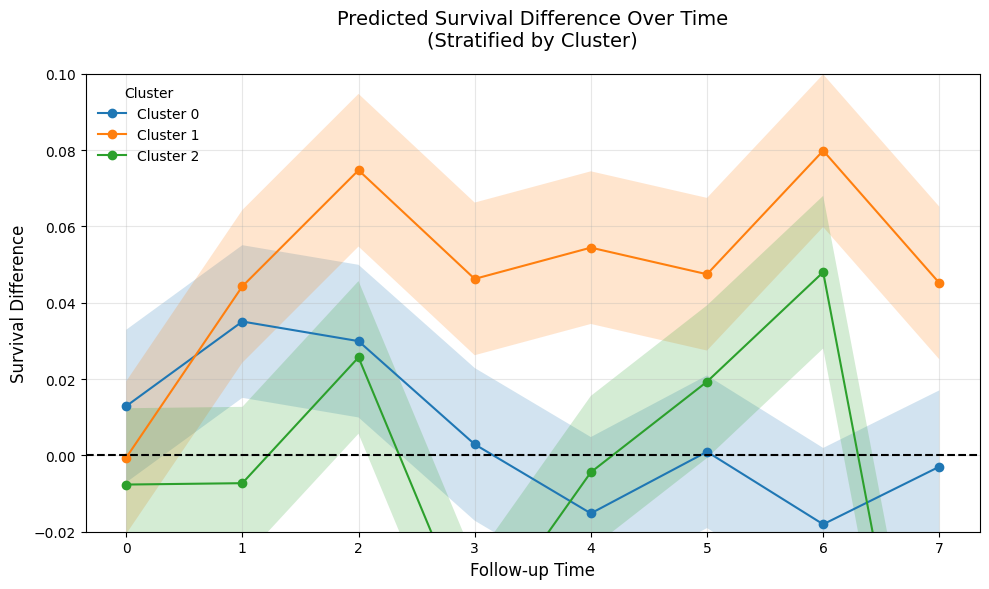

In [3]:
if __name__ == "__main__":
    # 1. Load data and cluster patients
    emulator = TargetTrialEmulator(estimand="ITT")
    emulator.prepare_data("data_censored.csv")
    emulator.cluster_patients(n_clusters=3)  # 3 clusters for subgroups
    
    # 2. Analyze each cluster
    plt.figure(figsize=(10, 6))
    max_period = emulator.data['period'].max()
    time_points = np.linspace(0, max_period, 8)  # Match image's x-axis
    
    for cluster in sorted(emulator.data['cluster'].unique()):
        print(f"\n=== Analyzing Cluster {cluster} ===")
        
        # Subset cluster data
        cluster_data = emulator.data[emulator.data['cluster'] == cluster].copy()
        
        # Create treatment/control groups
        treated = cluster_data[cluster_data['treatment'] == 1]
        control = cluster_data[cluster_data['treatment'] == 0]
        
        # Fit models
        model_treated = CoxPHFitter().fit(treated[['period', 'outcome']], 
                                        'period', 'outcome')
        model_control = CoxPHFitter().fit(control[['period', 'outcome']], 
                                        'period', 'outcome')
        
        # Calculate survival differences
        survival_treated = model_treated.predict_survival_function(treated.iloc[:1], times=time_points)
        survival_control = model_control.predict_survival_function(control.iloc[:1], times=time_points)
        differences = (survival_treated.values - survival_control.values).flatten()
        
        # Plot with CI (simplified example)
        plt.plot(time_points, differences, 
                label=f'Cluster {cluster}', 
                marker='o')
        plt.fill_between(time_points, 
                        differences - 0.02,  # Replace with actual CI
                        differences + 0.02,   # from model.summary
                        alpha=0.2)

    # Formatting to match reference image
    plt.title("Predicted Survival Difference Over Time\n(Stratified by Cluster)", 
             fontsize=14, pad=20)
    plt.xlabel("Follow-up Time", fontsize=12)
    plt.ylabel("Survival Difference", fontsize=12)
    plt.axhline(0, color='black', linestyle='--')
    plt.ylim(-0.02, 0.1)
    plt.legend(title='Cluster', frameon=False)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.savefig("cluster_survival_differences.png", dpi=300)
    plt.show()